In [14]:
import pandas as pd
import numpy as np
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import time
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
sns.set_style('darkgrid')
import shutil
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import time
from tqdm import tqdm
from sklearn.metrics import f1_score
from IPython.display import YouTubeVideo
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
pd.set_option('display.max_colwidth', None)  # or 199

In [15]:
def print_in_color(txt_msg,fore_tupple=(0,255,255),back_tupple=(100,100,100)):
    #prints the text_msg in the foreground color specified by fore_tupple with the background specified by back_tupple 
    #text_msg is the text, fore_tupple is foregroud color tupple (r,g,b), back_tupple is background tupple (r,g,b)
    # default parameter print in cyan foreground and gray background
    rf,gf,bf=fore_tupple
    rb,gb,bb=back_tupple
    msg='{0}' + txt_msg
    mat='\33[38;2;' + str(rf) +';' + str(gf) + ';' + str(bf) + ';48;2;' + str(rb) + ';' +str(gb) + ';' + str(bb) +'m' 
    print(msg .format(mat), flush=True)
    print('\33[0m', flush=True) # returns default print color to back to black
    return

# example default print
msg='test of default colors'
print_in_color(msg)

test of default colors



In [18]:
def make_dataframes(train_dir, val_dir):
    bad_images=[]
    dirlist=[train_dir, val_dir]
    names=['train', 'valid']
    zipdir=zip(names, dirlist)
    for name,d in zipdir:
        filepaths=[]
        labels=[]
        classlist=sorted(os.listdir(d) )       
        for klass in classlist:
            classpath=os.path.join(d, klass)           
            flist=sorted(os.listdir(classpath)) 
            desc=f'{name:6s}-{klass:25s}'
            for f in tqdm(flist, ncols=130,desc=desc, unit='files', colour='blue'):
                fpath=os.path.join(classpath,f)
                try:
                    img=cv2.imread(fpath)
                    shape=img.shape
                    filepaths.append(fpath)
                    labels.append(klass)
                except:
                    print (fpath, ' is an invalid image file')
                    bad_images.append(fpath)
        Fseries=pd.Series(filepaths, name='filepaths')
        Lseries=pd.Series(labels, name='labels')
        df=pd.concat([Fseries, Lseries], axis=1) 
        if name =='valid':
            valid_df=df       
        else:
            pdf=df 
    train_df, test_df=train_test_split(pdf, train_size=.8, shuffle=True, random_state=123, stratify=pdf['labels'])
    classes=sorted(train_df['labels'].unique())
    class_count=len(classes)
    sample_df=train_df.sample(n=50, replace=False)
    # calculate the average image height and with
    ht=0
    wt=0
    count=0
    for i in range(len(sample_df)):
        fpath=sample_df['filepaths'].iloc[i]
        try:
            img=cv2.imread(fpath)
            h=img.shape[0]
            w=img.shape[1]
            wt +=w
            ht +=h
            count +=1
        except:
            pass
    have=int(ht/count)
    wave=int(wt/count)
    aspect_ratio=have/wave
    print('number of classes in processed dataset= ', class_count)    
    counts=list(train_df['labels'].value_counts())    
    print('the maximum files in any class in train_df is ', max(counts), '  the minimum files in any class in train_df is ', min(counts))
    print('train_df length: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))  
    print('average image height= ', have, '  average image width= ', wave, ' aspect ratio h/w= ', aspect_ratio) 
    if len(bad_images)>0:
        msg='Below is a list of invalid image files'
        print_in_color(msg)
        for f in bad_images:
            print (f)
    return train_df, test_df, valid_df, classes, class_count

train_dir = r'Handbags Classification/Train Dataset'
val_dir=r'Handbags Classification/Valid Dataset'
train_df, test_df, valid_df, classes, class_count=make_dataframes(train_dir, val_dir)
    

valid -Tote Bag                 : 100%|█████████████████████████████████████████████████████| 100/100 [00:00<00:00, 253.87files/s]


number of classes in processed dataset=  5
the maximum files in any class in train_df is  440   the minimum files in any class in train_df is  440
train_df length:  2200   test_df length:  550   valid_df length:  500
average image height=  482   average image width=  442  aspect ratio h/w=  1.090497737556561


In [19]:
def trim(df, max_samples, min_samples, column):
    df=df.copy()
    classes=df[column].unique()
    class_count=len(classes)
    length=len(df)
    print ('dataframe initially is of length ',length, ' with ', class_count, ' classes')
    groups=df.groupby(column)    
    trimmed_df = pd.DataFrame(columns = df.columns)
    groups=df.groupby(column)
    for label in df[column].unique():         
        group=groups.get_group(label)
        count=len(group)        
        if count > max_samples:
            sampled_group=group.sample(n=max_samples, random_state=123,axis=0)
            trimmed_df=pd.concat([trimmed_df, sampled_group], axis=0)            
        else:
            if count>=min_samples:
                sampled_group=group        
                trimmed_df=pd.concat([trimmed_df, sampled_group], axis=0)
    print('after trimming, the maximum samples in any class is now ',max_samples, ' and the minimum samples in any class is ', min_samples)
    classes=trimmed_df[column].unique()# return this in case some classes have less than min_samples
    class_count=len(classes) # return this in case some classes have less than min_samples
    length=len(trimmed_df)
    print ('the trimmed dataframe now is of length ',length, ' with ', class_count, ' classes')
    return trimmed_df, classes, class_count


max_samples=300
min_samples=300
column= 'labels'
train_df, classes, class_count=trim(train_df, max_samples, min_samples, column)

dataframe initially is of length  2200  with  5  classes
after trimming, the maximum samples in any class is now  300  and the minimum samples in any class is  300
the trimmed dataframe now is of length  1500  with  5  classes


In [20]:
def balance(df, n, working_dir, img_size):
    df=df.copy()
    print('Initial length of dataframe is ', len(df))
    aug_dir=os.path.join(working_dir, 'aug')# directory to store augmented images
    if os.path.isdir(aug_dir):# start with an empty directory
        shutil.rmtree(aug_dir)
    os.mkdir(aug_dir)        
    for label in df['labels'].unique():    
        dir_path=os.path.join(aug_dir,label)    
        os.mkdir(dir_path) # make class directories within aug directory
    # create and store the augmented images  
    total=0
    gen=ImageDataGenerator(horizontal_flip=True,  rotation_range=20, width_shift_range=.2,
                                  height_shift_range=.2, zoom_range=.2)
    groups=df.groupby('labels') # group by class
    for label in df['labels'].unique():  # for every class               
        group=groups.get_group(label)  # a dataframe holding only rows with the specified label 
        sample_count=len(group)   # determine how many samples there are in this class  
        if sample_count< n: # if the class has less than target number of images
            aug_img_count=0
            delta=n - sample_count  # number of augmented images to create
            target_dir=os.path.join(aug_dir, label)  # define where to write the images
            msg='{0:40s} for class {1:^30s} creating {2:^5s} augmented images'.format(' ', label, str(delta))
            print(msg, '\r', end='') # prints over on the same line
            aug_gen=gen.flow_from_dataframe( group,  x_col='filepaths', y_col=None, target_size=img_size,
                                            class_mode=None, batch_size=1, shuffle=False, 
                                            save_to_dir=target_dir, save_prefix='aug-', color_mode='rgb',
                                            save_format='jpg')
            while aug_img_count<delta:
                images=next(aug_gen)            
                aug_img_count += len(images)
            total +=aug_img_count
    print('Total Augmented images created= ', total)
    # create aug_df and merge with train_df to create composite training set ndf
    aug_fpaths=[]
    aug_labels=[]
    classlist=os.listdir(aug_dir)
    for klass in classlist:
        classpath=os.path.join(aug_dir, klass)     
        flist=os.listdir(classpath)    
        for f in flist:        
            fpath=os.path.join(classpath,f)         
            aug_fpaths.append(fpath)
            aug_labels.append(klass)
    Fseries=pd.Series(aug_fpaths, name='filepaths')
    Lseries=pd.Series(aug_labels, name='labels')
    aug_df=pd.concat([Fseries, Lseries], axis=1)         
    df=pd.concat([df,aug_df], axis=0).reset_index(drop=True)
    print('Length of augmented dataframe is now ', len(df))
    return df 

In [21]:
img_size=(224,224)
working_dir=r'./'

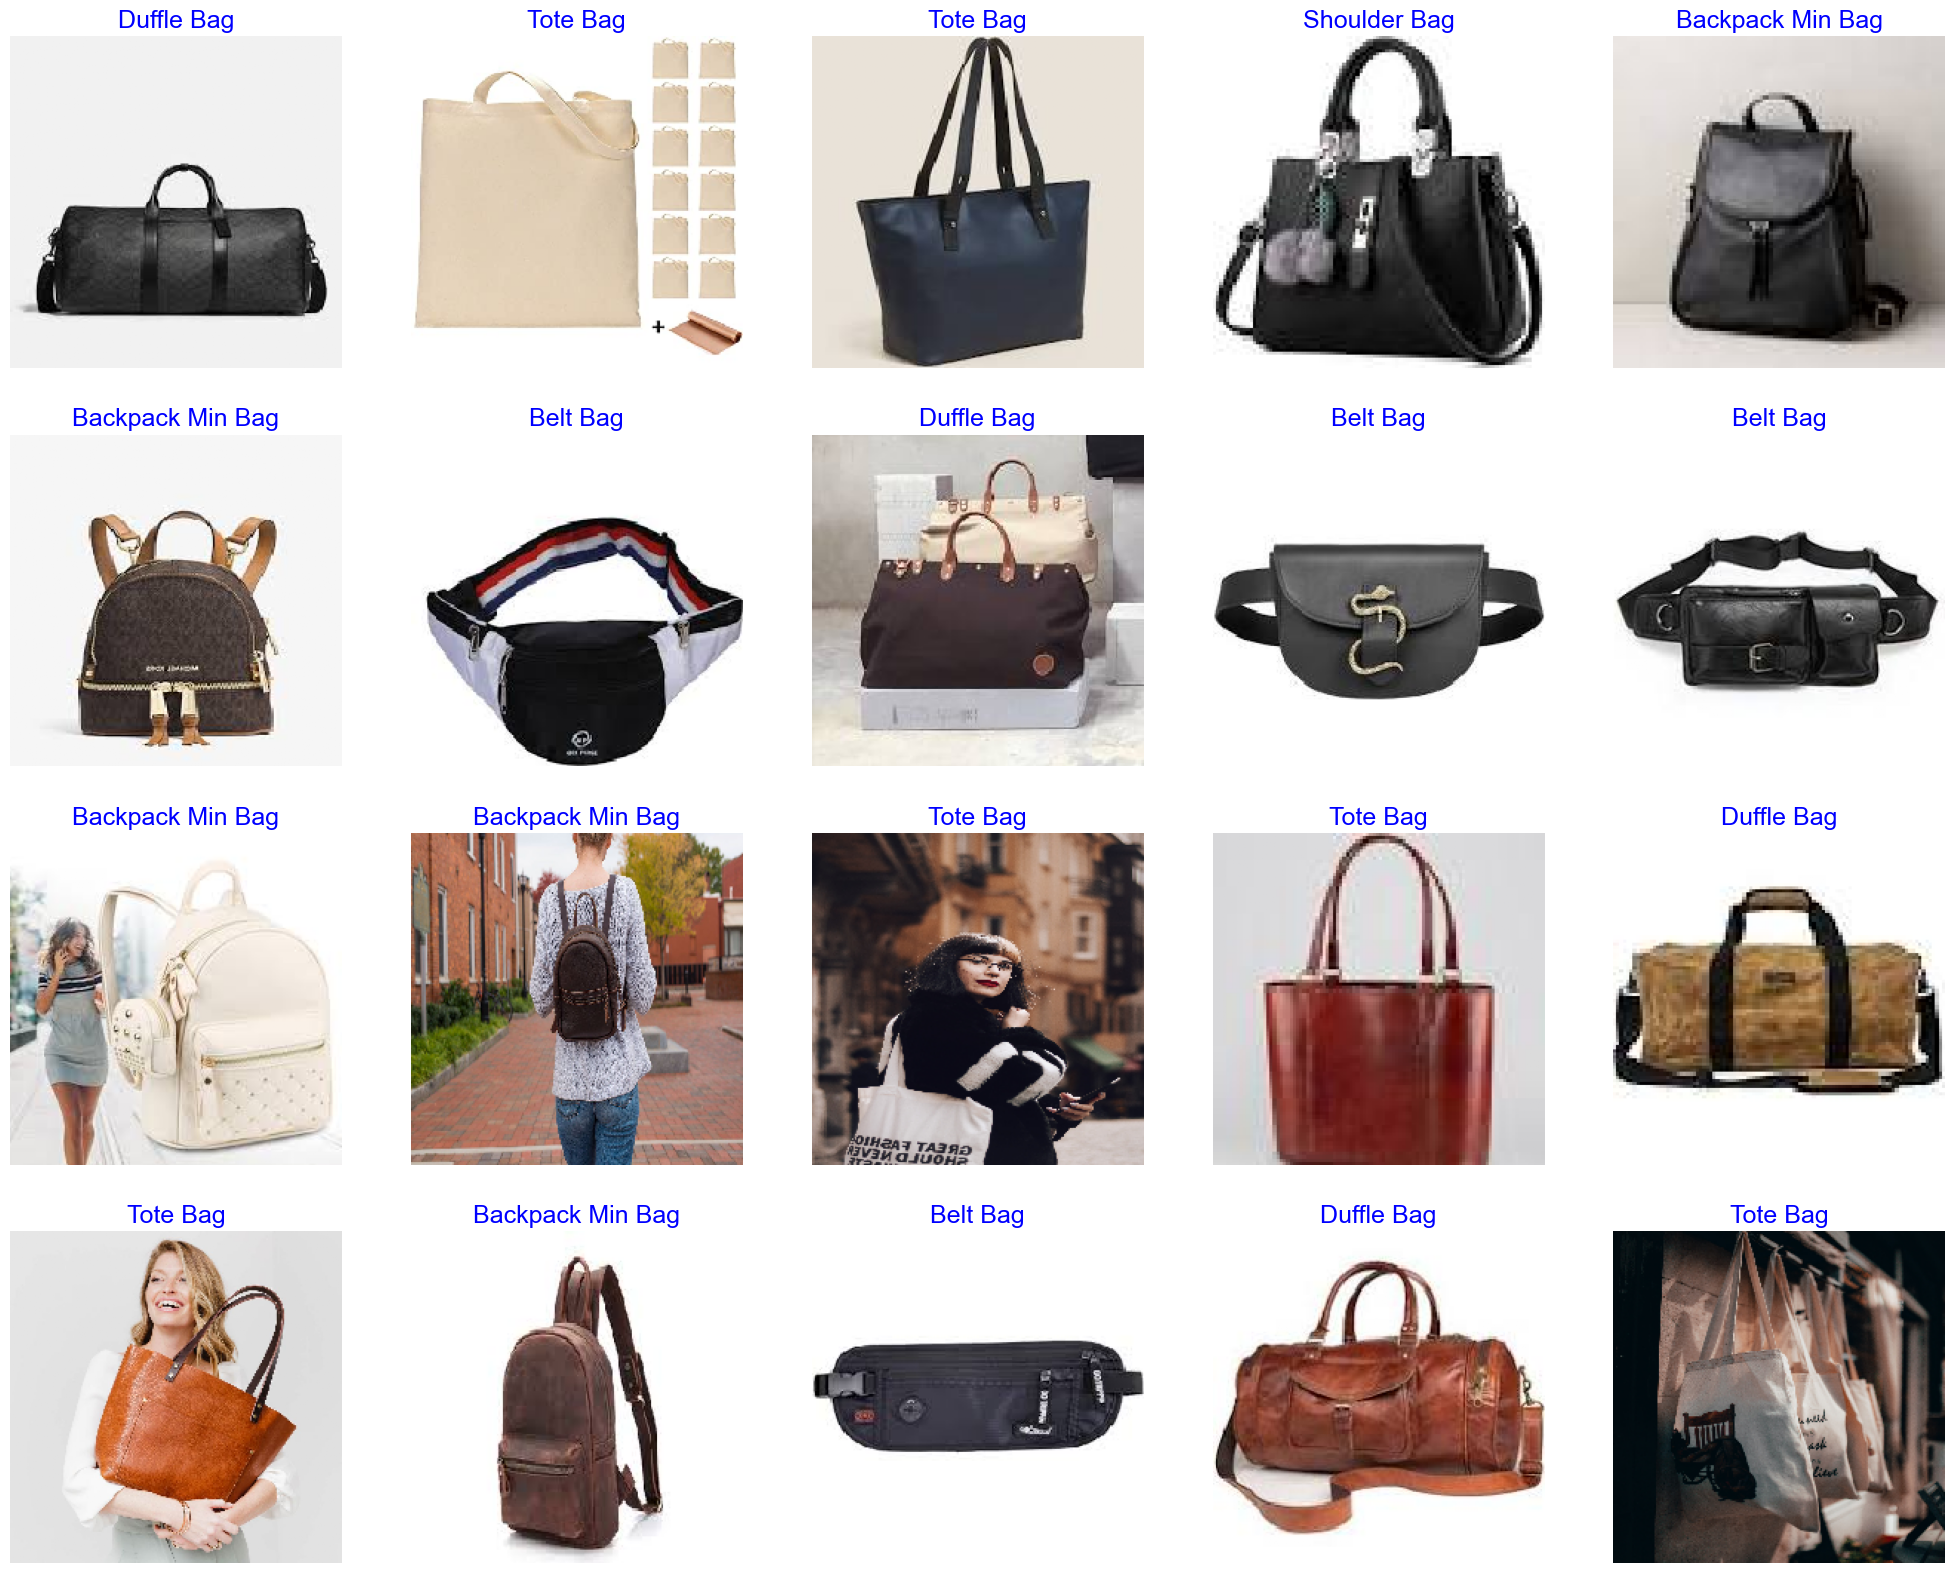

In [23]:
def show_image_samples(gen ):
    t_dict=gen.class_indices
    classes=list(t_dict.keys())    
    images,labels=next(gen) # get a sample batch from the generator 
    plt.figure(figsize=(25, 25))
    length=len(labels)
    if length<25:   #show maximum of 25 images
        r=length
    else:
        r=25
    for i in range(r):        
        plt.subplot(5, 5, i + 1)
        image=images[i] /255       
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=18)
        plt.axis('off')
    plt.show()
    
show_image_samples(train_gen )

In [25]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150,150, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation = 'relu'),
    tf.keras.layers.Dense(5, activation='softmax')

])

In [35]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs = {}):
        if(logs.get('loss') < 1e-4): #akan berhenti apabila memenuhi
            self.model.stop_training = True
            
cb = myCallback()

In [36]:
history=model.fit(x=train_gen,   epochs=10, verbose=1, callbacks= cb,  validation_data=valid_gen,
               validation_steps=None,  shuffle=False,  initial_epoch=0)

Epoch 1/10


InvalidArgumentError: Graph execution error:

Detected at node 'categorical_crossentropy/softmax_cross_entropy_with_logits' defined at (most recent call last):
    File "c:\Users\MSi-Modern\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\MSi-Modern\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "c:\Users\MSi-Modern\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "c:\Users\MSi-Modern\AppData\Local\Programs\Python\Python310\lib\site-packages\traitlets\config\application.py", line 978, in launch_instance
      app.start()
    File "c:\Users\MSi-Modern\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\kernelapp.py", line 712, in start
      self.io_loop.start()
    File "c:\Users\MSi-Modern\AppData\Local\Programs\Python\Python310\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\MSi-Modern\AppData\Local\Programs\Python\Python310\lib\asyncio\base_events.py", line 600, in run_forever
      self._run_once()
    File "c:\Users\MSi-Modern\AppData\Local\Programs\Python\Python310\lib\asyncio\base_events.py", line 1896, in _run_once
      handle._run()
    File "c:\Users\MSi-Modern\AppData\Local\Programs\Python\Python310\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\MSi-Modern\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "c:\Users\MSi-Modern\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "c:\Users\MSi-Modern\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "c:\Users\MSi-Modern\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "c:\Users\MSi-Modern\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "c:\Users\MSi-Modern\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\MSi-Modern\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 2885, in run_cell
      result = self._run_cell(
    File "c:\Users\MSi-Modern\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 2940, in _run_cell
      return runner(coro)
    File "c:\Users\MSi-Modern\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\MSi-Modern\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 3139, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\MSi-Modern\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 3318, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\MSi-Modern\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 3378, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\MSi-Modern\AppData\Local\Temp\ipykernel_19752\337686882.py", line 1, in <module>
      history=model.fit(x=train_gen,   epochs=10, verbose=1, callbacks= cb,  validation_data=valid_gen,
    File "c:\Users\MSi-Modern\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\MSi-Modern\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\MSi-Modern\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "c:\Users\MSi-Modern\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\MSi-Modern\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "c:\Users\MSi-Modern\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 994, in train_step
      loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "c:\Users\MSi-Modern\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1052, in compute_loss
      return self.compiled_loss(
    File "c:\Users\MSi-Modern\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\compile_utils.py", line 265, in __call__
      loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "c:\Users\MSi-Modern\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\losses.py", line 152, in __call__
      losses = call_fn(y_true, y_pred)
    File "c:\Users\MSi-Modern\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\losses.py", line 272, in call
      return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "c:\Users\MSi-Modern\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\losses.py", line 1990, in categorical_crossentropy
      return backend.categorical_crossentropy(
    File "c:\Users\MSi-Modern\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\backend.py", line 5535, in categorical_crossentropy
      return tf.nn.softmax_cross_entropy_with_logits(
Node: 'categorical_crossentropy/softmax_cross_entropy_with_logits'
logits and labels must be broadcastable: logits_size=[45,5] labels_size=[20,5]
	 [[{{node categorical_crossentropy/softmax_cross_entropy_with_logits}}]] [Op:__inference_train_function_927]

In [25]:
model.compile(
    optimizer= 'RMSprop',
    loss= 'categorical_crossentropy',
    metrics=['accuracy']
)

In [26]:
## callback
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs = {}):
        if(logs.get('loss') < 1e-4): #akan berhenti apabila memenuhi
            self.model.stop_training = True
            
cb = myCallback()

In [27]:
history = model.fit(
    train_generator,
    epochs=10,
    validation_data = val_generator, callbacks = cb
)

Epoch 1/10
86/86 [==============================] - 50s 570ms/step - loss: 0.2114 - accuracy: 0.9709 - val_loss: 3.0879 - val_accuracy: 0.5800
Epoch 2/10
86/86 [==============================] - 49s 565ms/step - loss: 0.0582 - accuracy: 0.9895 - val_loss: 3.1647 - val_accuracy: 0.5840
Epoch 3/10
86/86 [==============================] - 49s 568ms/step - loss: 0.0448 - accuracy: 0.9895 - val_loss: 3.6800 - val_accuracy: 0.5720
Epoch 4/10
86/86 [==============================] - 48s 560ms/step - loss: 0.0433 - accuracy: 0.9909 - val_loss: 3.0125 - val_accuracy: 0.5560
Epoch 5/10
86/86 [==============================] - 48s 559ms/step - loss: 0.0726 - accuracy: 0.9851 - val_loss: 3.4318 - val_accuracy: 0.5500
Epoch 6/10
86/86 [==============================] - 48s 556ms/step - loss: 0.0595 - accuracy: 0.9873 - val_loss: 3.4165 - val_accuracy: 0.5860
Epoch 7/10
86/86 [==============================] - 49s 571ms/step - loss: 0.0407 - accuracy: 0.9902 - val_loss: 4.0273 - val_accuracy: 0.5620

In [28]:
#train
y_acctrain = history.history['accuracy']
y_accval = history.history['val_accuracy']

#validation
y_losstrain = history.history['loss']
y_lossval = history.history['val_loss']

#epoch
x_ = range(len(y_acctrain))

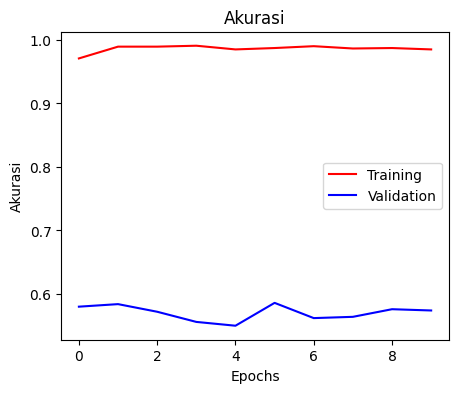

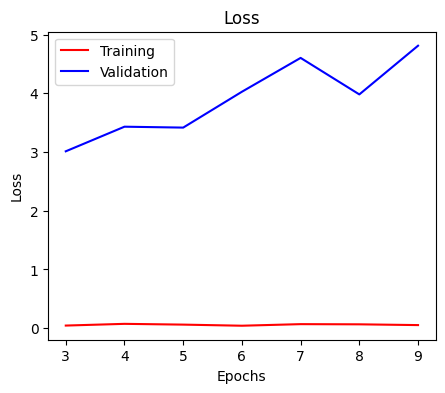

In [29]:
plt.figure(1, figsize=(5,4))
plt.plot(x_, y_acctrain, c='r', label='Training')
plt.plot(x_, y_accval, c='b', label='Validation')
plt.title('Akurasi')
plt.xlabel('Epochs')
plt.ylabel('Akurasi')
plt.legend()

plt.figure(2, figsize=(5,4))
plt.plot(x_[3:], y_losstrain[3:], c='r', label='Training')
plt.plot(x_[3:], y_lossval[3:], c='b', label='Validation')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()